In [25]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score


In [24]:
def simulate_data(n=100, p=1000, n_informative=50, block_size=50, rho=0.6, seed=42):
    np.random.seed(seed)

    # Block-correlated covariance matrix
    n_blocks = p // block_size
    Sigma = np.eye(p)
    for b in range(n_blocks):
        start = b * block_size
        end = start + block_size
        Sigma[start:end, start:end] = rho
        np.fill_diagonal(Sigma[start:end, start:end], 1.0)

    # Generate features X ~ N(0, Sigma)
    mean = np.zeros(p)
    X = np.random.multivariate_normal(mean, Sigma, size=n)
    X = StandardScaler().fit_transform(X)

    # Sparse signal
    beta = np.zeros(p)
    informative_idx = np.random.choice(p, n_informative, replace=False)
    beta[informative_idx] = np.random.uniform(1.5, 3.0, size=n_informative)

    # Labels via linear discriminant model
    logits = X @ beta + np.random.normal(0, 1, size=n)
    y = np.where(logits > 0, 1, -1)

    return X, y, beta, informative_idx


In [21]:
def fair_selection(X, y, d):
    corrs = np.abs(np.corrcoef(X.T, y)[-1, :-1])
    top_d_idx = np.argsort(corrs)[-d:]
    X_selected = X[:, top_d_idx]
    return X_selected, top_d_idx


In [22]:
def evaluate_models_shared_features(X_train, y_train, X_test, y_test, d_range, C=0.1):
    fair_accs = []
    diag_accs = []
    lasso_accs = []

    for d in d_range:
        # Select top-d features using FAIR
        X_train_sel, top_d_idx = fair_selection(X_train, y_train, d)
        X_test_sel = X_test[:, top_d_idx]

        # FAIR + LDA
        clf_fair = LinearDiscriminantAnalysis()
        clf_fair.fit(X_train_sel, y_train)
        fair_accs.append(accuracy_score(y_test, clf_fair.predict(X_test_sel)))

        # Diagonal LDA
        clf_diag = LinearDiscriminantAnalysis(solver='lsqr', shrinkage=None)
        clf_diag.fit(X_train_sel, y_train)
        diag_accs.append(accuracy_score(y_test, clf_diag.predict(X_test_sel)))

        # Lasso Logistic
        clf_lasso = LogisticRegression(penalty='l1', solver='saga', C=C, max_iter=1000)
        clf_lasso.fit(X_train_sel, y_train)
        lasso_accs.append(accuracy_score(y_test, clf_lasso.predict(X_test_sel)))

    return fair_accs, diag_accs, lasso_accs


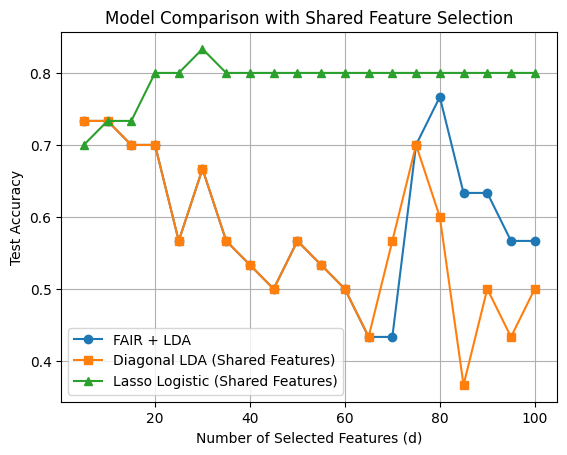

In [23]:
# Simulate data
X, y, beta, informative_idx = simulate_data()

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Benchmark
d_range = range(5, 105, 5)
fair_accs, diag_accs, lasso_accs = evaluate_models_shared_features(X_train, y_train, X_test, y_test, d_range)

# Plot
plt.plot(d_range, fair_accs, label='FAIR + LDA', marker='o')
plt.plot(d_range, diag_accs, label='Diagonal LDA (Shared Features)', marker='s')
plt.plot(d_range, lasso_accs, label='Lasso Logistic (Shared Features)', marker='^')
plt.xlabel("Number of Selected Features (d)")
plt.ylabel("Test Accuracy")
plt.title("Model Comparison with Shared Feature Selection")
plt.legend()
plt.grid(True)
plt.show()


In [26]:
from sklearn.feature_selection import mutual_info_classif
from sklearn.model_selection import train_test_split

In [27]:
def rank_by_correlation(X, y):
    return np.argsort(np.abs(np.corrcoef(X.T, y)[-1, :-1]))[::-1]

def rank_by_mutual_info(X, y):
    mi = mutual_info_classif(X, y, discrete_features=False)
    return np.argsort(mi)[::-1]

def rank_by_t_stat(X, y):
    group0 = X[y == 0]
    group1 = X[y == 1]
    mean_diff = np.abs(group0.mean(axis=0) - group1.mean(axis=0))
    pooled_std = np.sqrt((group0.var(axis=0) + group1.var(axis=0)) / 2)
    t_stats = mean_diff / (pooled_std + 1e-6)
    return np.argsort(t_stats)[::-1]


In [28]:
def precision_recall(selected_idx, informative_idx):
    selected_set = set(selected_idx)
    informative_set = set(informative_idx)
    tp = len(selected_set & informative_set)
    fp = len(selected_set - informative_set)
    precision = tp / (tp + fp + 1e-6)
    recall = tp / len(informative_set)
    return precision, recall


In [29]:
def run_analysis(X, y, informative_idx, d_range):
    methods = {
        'Correlation': rank_by_correlation(X, y),
        'Mutual Info': rank_by_mutual_info(X, y),
        'T-Statistic': rank_by_t_stat(X, y)
    }

    results = {name: {'precision': [], 'recall': []} for name in methods}

    for name, ranked_idx in methods.items():
        for d in d_range:
            selected_idx = ranked_idx[:d]
            prec, rec = precision_recall(selected_idx, informative_idx)
            results[name]['precision'].append(prec)
            results[name]['recall'].append(rec)

    return results


In [30]:
def plot_precision_recall(results, d_range):
    plt.figure(figsize=(12, 5))

    # Precision
    plt.subplot(1, 2, 1)
    for name in results:
        plt.plot(d_range, results[name]['precision'], label=name)
    plt.title("Precision vs. Number of Selected Features")
    plt.xlabel("d")
    plt.ylabel("Precision")
    plt.legend()
    plt.grid(True)

    # Recall
    plt.subplot(1, 2, 2)
    for name in results:
        plt.plot(d_range, results[name]['recall'], label=name)
    plt.title("Recall vs. Number of Selected Features")
    plt.xlabel("d")
    plt.ylabel("Recall")
    plt.legend()
    plt.grid(True)

    plt.tight_layout()
    plt.show()


/tmp/ipython-input-4016018412.py:11: RuntimeWarning: Mean of empty slice.
  mean_diff = np.abs(group0.mean(axis=0) - group1.mean(axis=0))
/usr/local/lib/python3.11/dist-packages/numpy/_core/_methods.py:130: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(
/tmp/ipython-input-4016018412.py:12: RuntimeWarning: Degrees of freedom <= 0 for slice
  pooled_std = np.sqrt((group0.var(axis=0) + group1.var(axis=0)) / 2)
/usr/local/lib/python3.11/dist-packages/numpy/_core/_methods.py:175: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean,
/usr/local/lib/python3.11/dist-packages/numpy/_core/_methods.py:207: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(


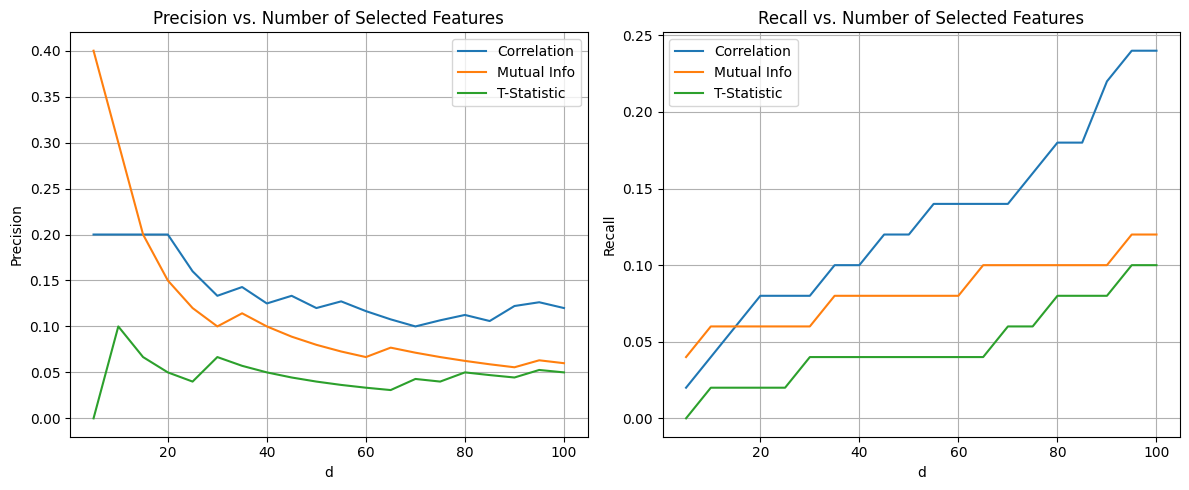

In [33]:
X, y, _, informative_idx = simulate_data()
d_range = range(5, 105, 5)
results = run_analysis(X, y, informative_idx, d_range)
plot_precision_recall(results, d_range)
